Primeras claves en el diccionario JSON: ['../../../../human_pose_images_filtrado_1_persona/images_almenos_un_pie_FINAL/000436327.jpg', '../../../../human_pose_images_filtrado_1_persona/images_almenos_un_pie_FINAL/000460055.jpg', '../../../../human_pose_images_filtrado_1_persona/images_almenos_un_pie_FINAL/000575866.jpg']
Total batches in training set: 12
Total batches in validation set: 2
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 972ms/step - loss: 0.2592 - val_loss: 0.2612
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 781ms/step - loss: 0.2607 - val_loss: 0.2561
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 762ms/step - loss: 0.2519 - val_loss: 0.2503
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 777ms/step - loss: 0.2515 - val_loss: 0.2435
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 784ms/step - loss: 0.2364 - val_loss: 0.2352
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 765ms/step - loss: 0.2271 - val_loss: 0.2250
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 768ms/step - loss: 0.2231 - val_loss: 0.2124

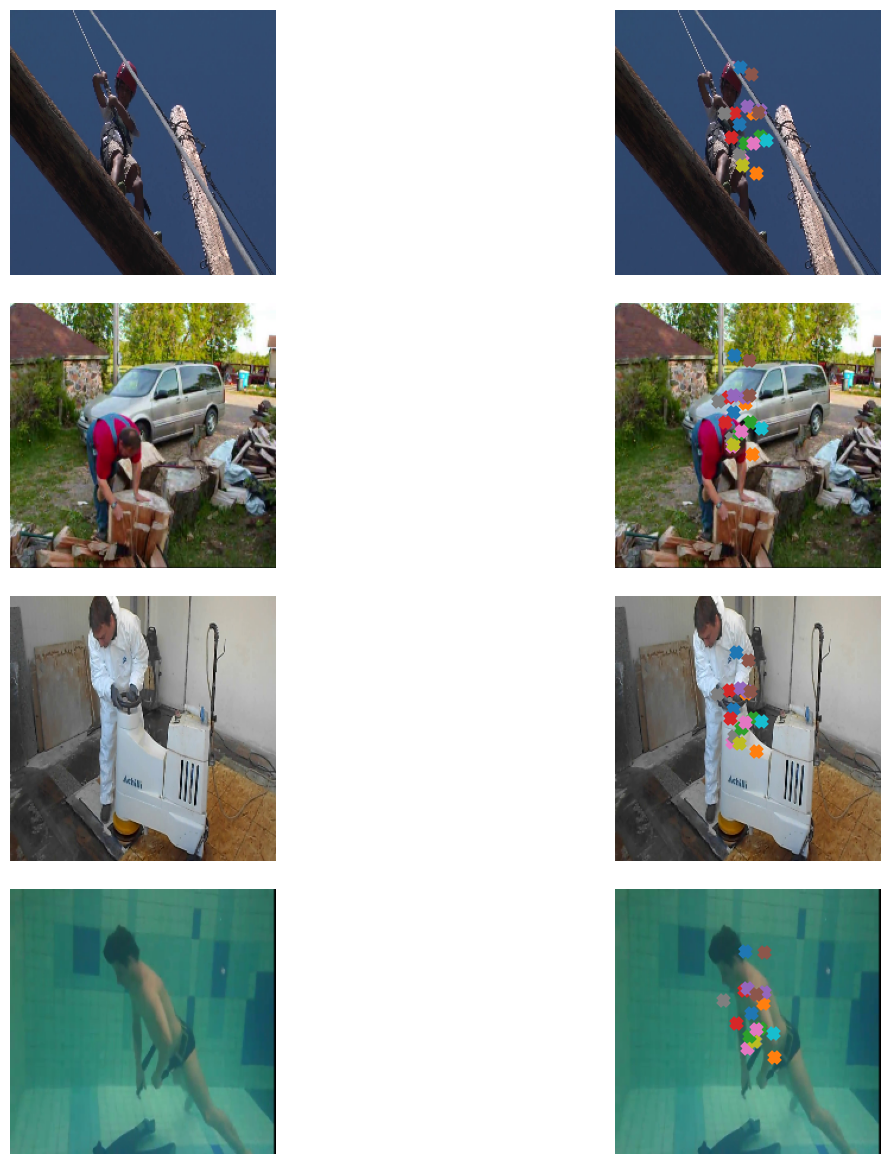

In [3]:
from keras import layers, models
import keras
import tensorflow as tf
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa
from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import json

# HIPERPARÁMETROS
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20
NUM_KEYPOINTS = 18 * 2

# Leer datos JSON Dict
IMG_DIR = "../../../../human_pose_images_filtrado_1_persona/images_almenos_un_pie_FINAL/"
JSON = "./labelsDEF.json"

# Cargar las anotaciones del archivo JSON.
with open(JSON) as infile:
    json_data = json.load(infile)

# Crear diccionario asociando anotaciones de la imagen con la ruta completa de la imagen.
json_dict = {i["img_path"]: i for i in json_data}

# Imprimir las primeras claves para verificar
print("Primeras claves en el diccionario JSON:", list(json_dict.keys())[:3])

# Utilidad para leer una imagen y obtener sus anotaciones.
def get_image(name):
    
    try:
        #print(os.path.isdir("../../../../human_pose_images_filtrado_1_persona"))
        data = json_dict[name]
    except KeyError:
        #print(img_full_path)
        print(f"Imagen {name} no encontrada en los datos JSON.")
        return None

    img_data = plt.imread(name)
    # Si la imagen es RGBA convertirla a RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

# Probar la función con depuración
# image_data = get_image("050442104.jpg")
# if image_data:
#     pprint(image_data)


#Funcion comprobacion visualizacion data
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_image(sample)
    image = data["img_data"]
    keypoint = data["joints"]

    images.append(image)
    keypoints.append(keypoint)

# visualize_keypoints(images, keypoints)

class KeyPointsDataset(keras.utils.PyDataset):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True, **kwargs):
        super().__init__(**kwargs)
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_image(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, NUM_KEYPOINTS)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)
    
    
    ##DEFINIR METODO AUMENTADO DE DATOS
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        # iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
        iaa.Sometimes(0.3, iaa.Multiply((0.9, 1.1))),  # Ajustar brillo con una probabilidad del 30%
        iaa.Sometimes(0.3, iaa.LinearContrast((0.9, 1.1))),  # Ajustar contraste con una probabilidad del 30%
        iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.02*255))),  # Agregar ruido con una probabilidad del 30%
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

train_dataset = KeyPointsDataset(
    train_keys, train_aug, use_multiprocessing=False
)
validation_dataset = KeyPointsDataset(
    validation_keys, test_aug, train=False, use_multiprocessing=False
)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))

sample_keypoints = sample_keypoints[:4].reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE
#visualize_keypoints(sample_images[:4], sample_keypoints)

# def get_model():
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#     # Capa convolucional 1
#     x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     # Capa convolucional 2
#     x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     # Capa convolucional 3
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     # Capa convolucional 4
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2))(x)

#     # Capa de Flatten y densa
#     x = layers.Flatten()(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.2)(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.2)(x)  # Incrementar la tasa de dropout

#     # Capa de salida
#     outputs = layers.Dense(NUM_KEYPOINTS)(x)

#     return models.Model(inputs, outputs, name="improved_keypoint_detector")

model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)


sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE

# Ground-truth
# visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

#TODO mejorar predicciones y ordenar entrada y salida

In [4]:
def plot_history(history):
    
    loss         = history.history["loss"]

    val_loss     = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)


    # Plot Loss
    plt.plot(epochs, loss, "r--", label = "Train loss" )
    plt.plot(epochs, val_loss ,  "b", label = "Validation loss" )
    
    plt.title("Training and validation loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.show()

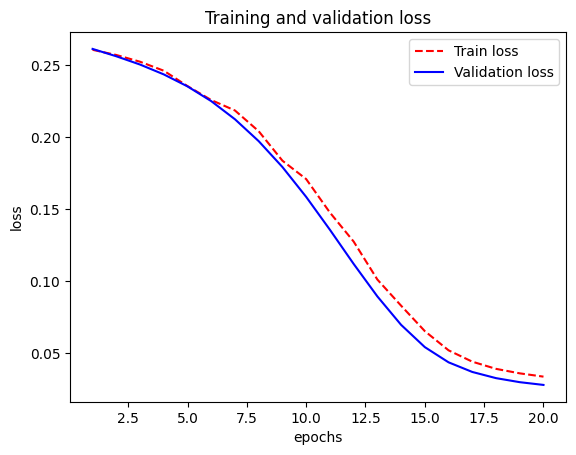

In [5]:
plot_history(history)

In [2]:


def get_model():
    # Pre trained

    backbone = keras.applications.MobileNetV2(
        include_top=True,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    backbone.trainable = False

    # Capa de Flatten y densa
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Incrementar la tasa de dropout
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Incrementar la tasa de dropout

    # Capa de salida
    outputs = layers.Dense(NUM_KEYPOINTS)(x)

    return models.Model(inputs, outputs, name="improved_keypoint_detector")